In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd.functional import hessian

from distshift_dataset import UniqueDistshiftDataset
from models import AutoencodingWorldModel, SeparatedAutoencodingWorldModel
from train import get_dataloaders, device
from fim import get_and_save_FIM_data, load_FIM, load_FIM_inv

# Load Data

In [2]:
world_model = AutoencodingWorldModel(.001, hidden_layers=[16, 16, 32], transition_layers=[32])
# world_model.load_state_dict(torch.load(f"data/models/autoencoding_161632.ckpt"))
world_model.load_state_dict(torch.load(f"data/models/{world_model.model_name}_many.ckpt"))
world_model = world_model.to(device)

# train_dataset = UniqueDistshiftDataset("distshift-v0")
# train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
# test_dataset = UniqueDistshiftDataset("distshift-v1")
# test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
train_dataset = UniqueDistshiftDataset(["distshift-v0", "distshift-v1"])
train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

In [3]:
jacobian_strategy = "all"
# FIM, FIM_inv = get_and_save_FIM_data(world_model, train_dataloader, strategy=jacobian_strategy)
FIM = load_FIM(world_model.model_name, strategy=jacobian_strategy)
FIM_inv = load_FIM_inv(world_model.model_name, strategy=jacobian_strategy)

In [4]:
FIM.shape

(17027, 17027)

In [4]:
def flatten_params(model: nn.Module):
    """
    flattens all parameters into a single column vector. Returns the dictionary to recover them
    :param: parameters: a generator or list of all the parameters
    :return: a dictionary: {"params": [#params, 1],
    "indices": [(start index, end index) for each param] **Note end index in uninclusive**

    """
    flat_params = []
    names = []
    for (name, param) in model.named_parameters():
        flat_params.append(torch.flatten(param))
        names.append(name)
    # l = [torch.flatten(p) for p in parameters]
    
    indices = []
    s = 0
    for p in flat_params:
        size = p.shape[0]
        indices.append((s, s+size))
        s += size
    flat_params = torch.cat(flat_params).view(-1, 1)
    return {"params": flat_params, "indices": indices, "names": names}


def recover_flattened(flat_params, indices, names, model):
    """
    Gives a list of recovered parameters from their flattened form
    :param flat_params: [#params, 1]
    :param indices: a list detaling the start and end index of each param [(start, end) for param]
    :param model: the model that gives the params with correct shapes
    :return: the params, reshaped to the ones in the model, with the same order as those in the model
    """
    l = [flat_params[s:e] for (s, e) in indices]
    for i, p in enumerate(model.parameters()):
        l[i] = l[i].view(*p.shape)
    from collections import OrderedDict
    
    state_dict = OrderedDict()
    for n, p in zip(names, l):
        state_dict[n] = p
    return state_dict
    # return l

# Plot Param Uncertainty

In [6]:
def plot_param_std(param_std, transition_start_idx=7408, decoder_start_idx=10704): 
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    indices = [0, transition_start_idx, decoder_start_idx, len(param_std)]
    names = ['encoder', 'transition', 'decoder']
    for idx, ax in enumerate(axes):
        model_param_std = param_std[indices[idx]:indices[idx+1]]
        # ax.scatter(range(len(model_param_var)), np.sqrt(model_param_var))
        ax.scatter(range(len(model_param_std)), np.sqrt(model_param_std))
        ax.set_yscale('log')
        # ax.set_ylim(1e-22, 1e-3)
        ax.set_title(names[idx])
    plt.show()
    
    
def plot_named_param_std(param_std, names, indices):
    fig, axes = plt.subplots(3, 6, figsize=(20, 12))
    offset = 0
    for i, (name, min_max_indices) in enumerate(zip(names, indices)):
        ax = axes[np.unravel_index(i, (3, 6))]
        model_param_std = param_std[min_max_indices[0]:min_max_indices[1]]
        ax.scatter(range(len(model_param_std)), np.sqrt(model_param_std))
        # ax.set_ylim(min_parameter_var, max_parameter_var)
        ax.set_yscale('log')
        # ax.set_ylim(1e-22, 1e-3)
        ax.set_title(name)
    plt.show()

In [21]:
def get_feature_map_corr(filter=False): 
    import json
    with open(f"data/param_var_161632_many.json", 'r') as f:
        param_std = json.load(f)
    kernel_keys = ['state_encoder.0.net.0.weight', 'state_encoder.1.net.0.weight', 'state_encoder.2.net.0.weight', 
                   'state_decoder.0.net.0.weight', 'state_decoder.1.net.0.weight', 'state_decoder.2.weight']
    kernel_names = ['Encoder Conv 1', 'Encoder Conv 2', 'Encoder Conv 3', 'Decoder Conv 1', 'Decoder Conv 2', 'Decoder Conv 3']
    
    for i, k in enumerate(kernel_keys):
        kernels = np.array(param_std[k])
        shape = kernels.shape
        if filter:
            kernels = kernels.reshape((shape[0], shape[1]*shape[2]*shape[3]))
        else:
            kernels = kernels.reshape((shape[0]*shape[1], shape[2]*shape[3]))
            
        # print(kernels.shape)
        # print(kernel_names[i] + (' filter' if filter else ' kernel'), f"p={scipy.stats.kruskal(*kernels)[1]}")
        print(kernel_names[i] + (' filter' if filter else ' kernel'), f"p={scipy.stats.levene(*np.log10(kernels))[1]}")
        # print(kernels.shape)
        # print(scipy.stats.kruskal(*kernels))
        # print(scipy.stats.f_oneway(kernels[0], kernels[1]))
        # print(kernel_names[i] + (' filter' if filter else ' kernel'))
    
    # # fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharey=True)
    # for i, k in enumerate(kernel_keys):
    #     unraveled_index = np.unravel_index(i, (2, 3))
    #     ax = axes[unraveled_index]
    #     kernels = np.array(param_std[k])
    #     shape = kernels.shape

    #     kernels = kernels[:, np.argsort(np.median(kernels, axis=0))]
    #     ax.boxplot(kernels)
    #     ax.set_yscale('log')
    #     ax.set_xticks([])
        
    #     ax.set_title(kernel_names[i])
    #     if unraveled_index[1] == 0:
    #         ax.set_ylabel(r"$\log \sqrt{var(\theta)}$")
    
    # if filter:
    #     plt.suptitle(f"Convolution Layer Filter Comparison (Sorted)")
    # else:
    #     plt.suptitle(f"Convolution Layer Kernel Comparison (Sorted)")
    # plt.savefig(f"data/results/{'filter' if filter else 'kernel'}_comparison.png")
    # plt.show()
    
get_feature_map_corr(filter=True)
get_feature_map_corr(filter=False)

Encoder Conv 1 filter p=1.7200414623128828e-05
Encoder Conv 2 filter p=0.07764537901748415
Encoder Conv 3 filter p=1.390725260891465e-10
Decoder Conv 1 filter p=2.5235652217247584e-100
Decoder Conv 2 filter p=2.6290774965823763e-24
Decoder Conv 3 filter p=7.661881624509085e-19
Encoder Conv 1 kernel p=6.185652384792191e-05
Encoder Conv 2 kernel p=1.559613048055635e-34
Encoder Conv 3 kernel p=3.800966926063996e-105
Decoder Conv 1 kernel p=5.442900613886666e-28
Decoder Conv 2 kernel p=6.132361243900863e-22
Decoder Conv 3 kernel p=3.265171490244413e-09


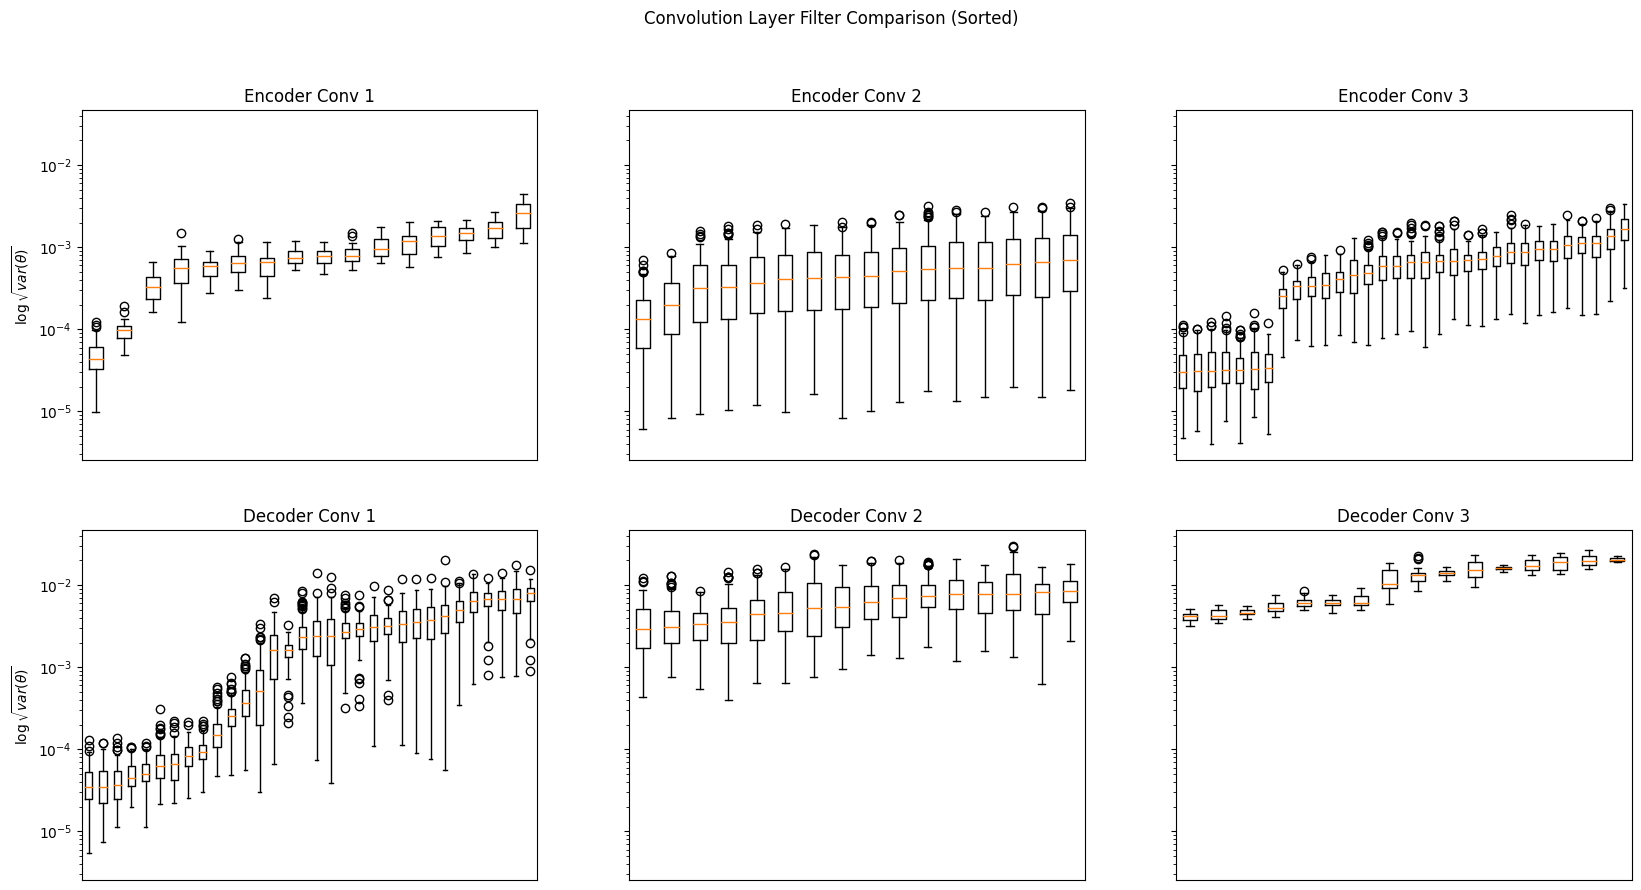

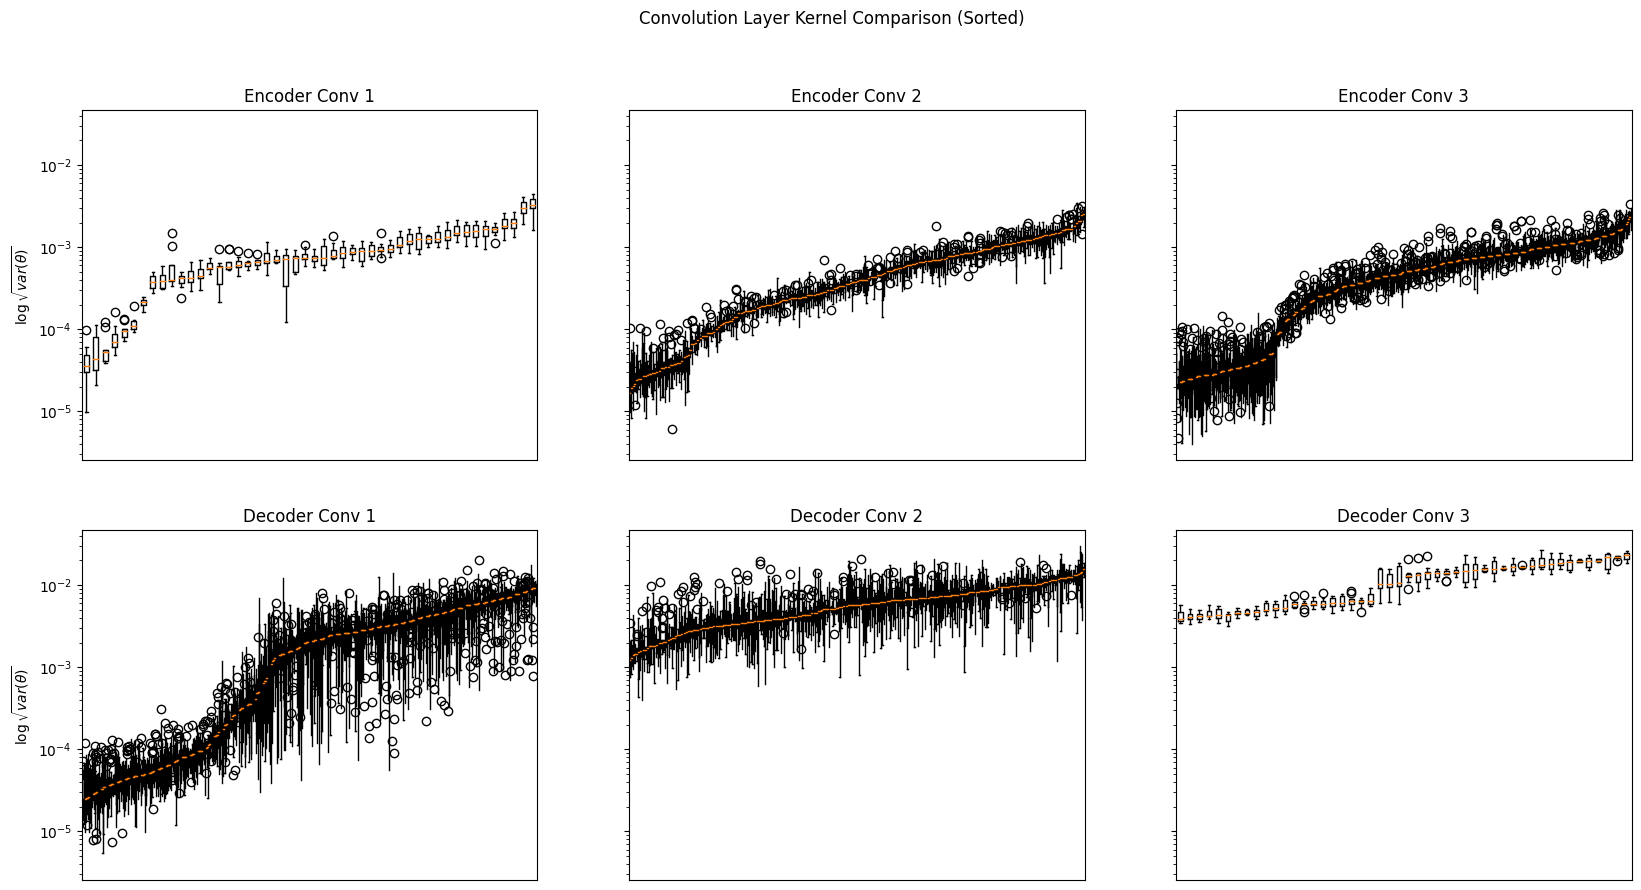

In [38]:
def plot_feature_map_boxplot_uncertainty(filter=False): 
    import json
    with open(f"data/param_var_161632_many.json", 'r') as f:
        param_std = json.load(f)
    kernel_keys = ['state_encoder.0.net.0.weight', 'state_encoder.1.net.0.weight', 'state_encoder.2.net.0.weight', 
                   'state_decoder.0.net.0.weight', 'state_decoder.1.net.0.weight', 'state_decoder.2.weight']
    kernel_names = ['Encoder Conv 1', 'Encoder Conv 2', 'Encoder Conv 3', 'Decoder Conv 1', 'Decoder Conv 2', 'Decoder Conv 3']
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharey=True)
    for i, k in enumerate(kernel_keys):
        unraveled_index = np.unravel_index(i, (2, 3))
        ax = axes[unraveled_index]
        kernels = np.array(param_std[k])
        shape = kernels.shape
        if filter:
            kernels = kernels.reshape((shape[0], shape[1]*shape[2]*shape[3])).T
        else:
            kernels = kernels.reshape((shape[0]*shape[1], shape[2]*shape[3])).T
        kernels = kernels[:, np.argsort(np.median(kernels, axis=0))]
        ax.boxplot(kernels)
        ax.set_yscale('log')
        ax.set_xticks([])
        
        ax.set_title(kernel_names[i])
        if unraveled_index[1] == 0:
            ax.set_ylabel(r"$\log \sqrt{var(\theta)}$")
    
    if filter:
        plt.suptitle(f"Convolution Layer Filter Comparison (Sorted)")
    else:
        plt.suptitle(f"Convolution Layer Kernel Comparison (Sorted)")
    plt.savefig(f"data/results/{'filter' if filter else 'kernel'}_comparison.png")
    plt.show()
    
plot_feature_map_boxplot_uncertainty(filter=True)
plot_feature_map_boxplot_uncertainty(filter=False)

In [12]:
param_std = np.sqrt(np.diag(FIM_inv))

In [13]:
flat_param_dict = flatten_params(world_model)

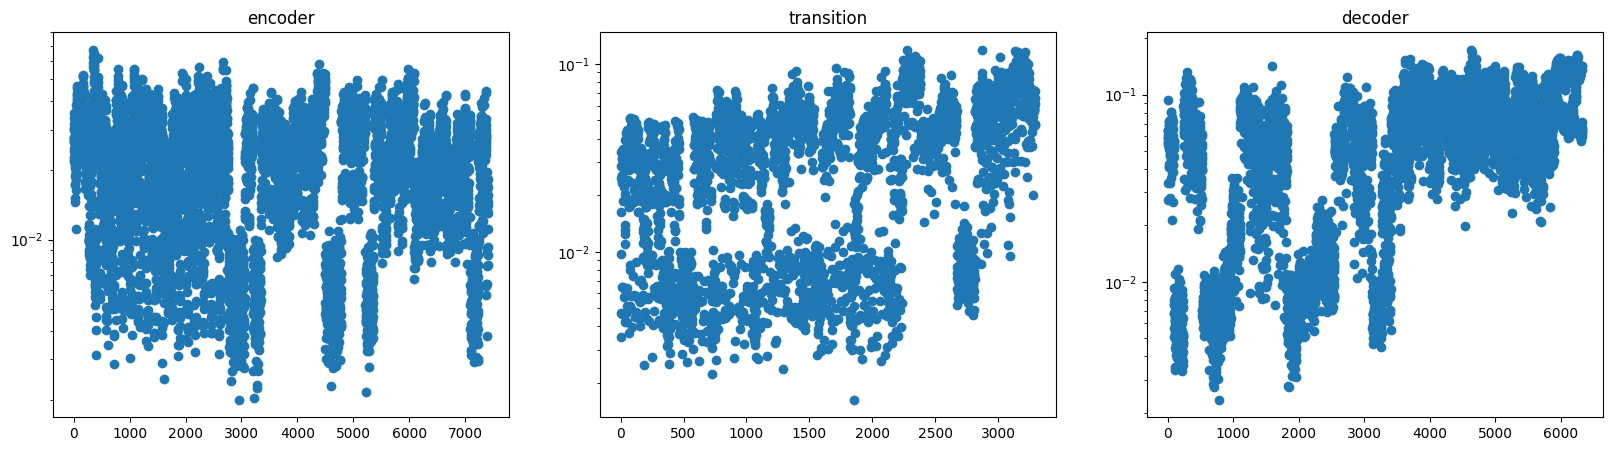

In [14]:
plot_param_std(param_std)

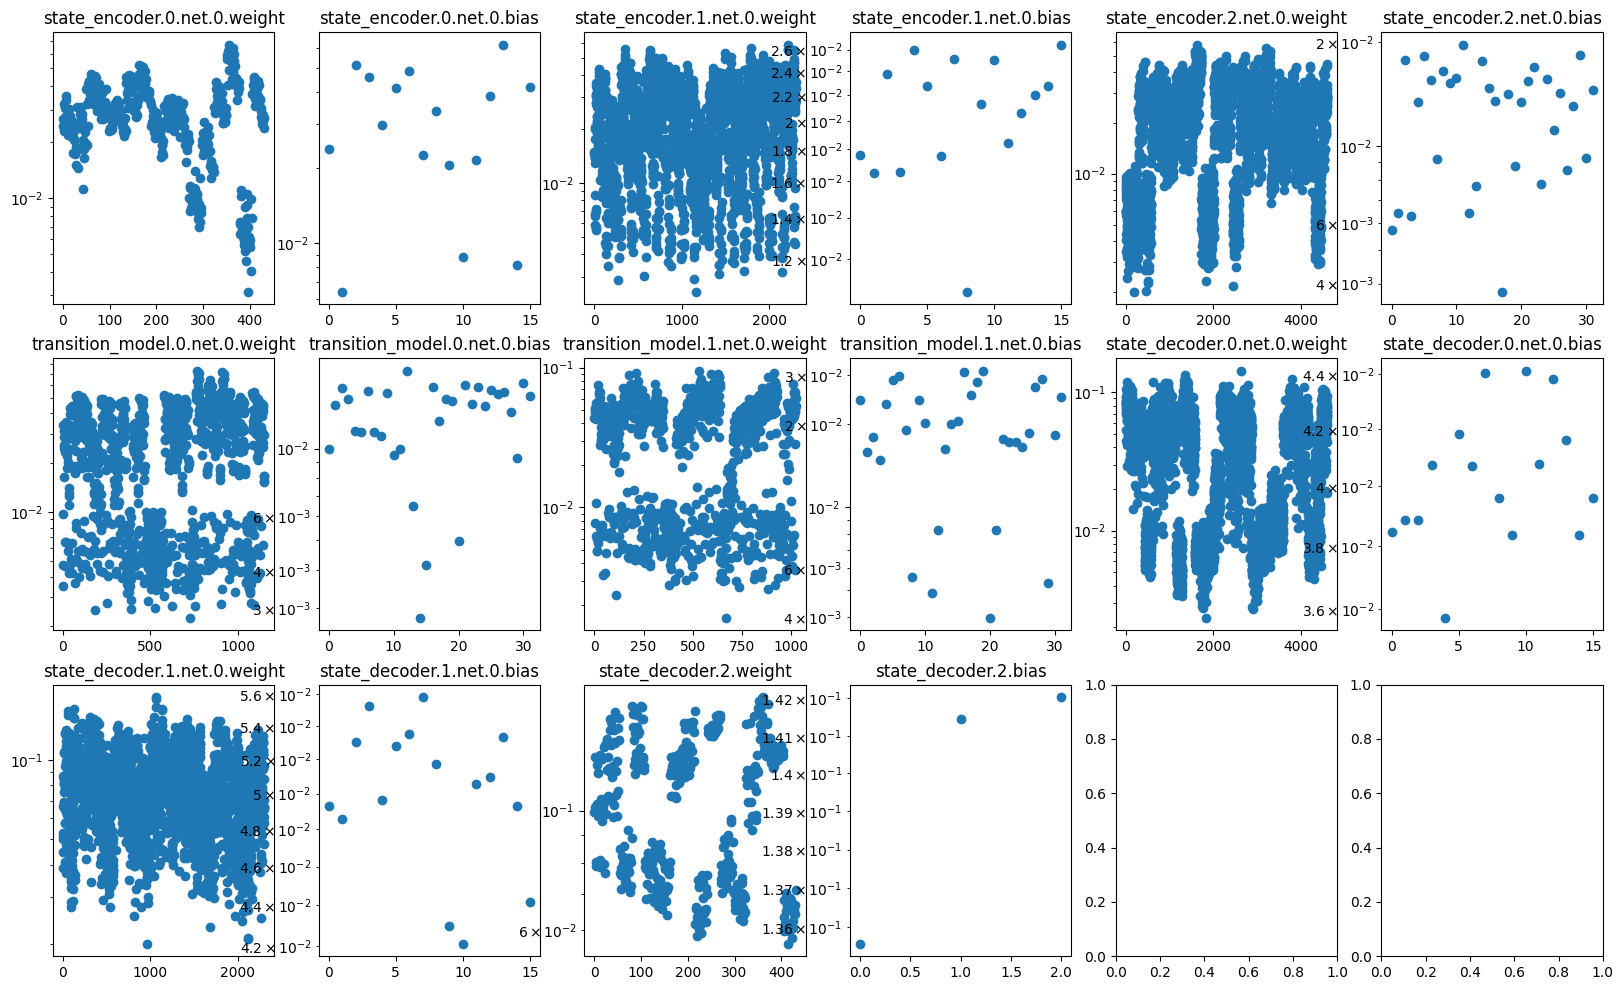

In [15]:
plot_named_param_std(param_std, flat_param_dict["names"], flat_param_dict["indices"])

In [ ]:
plot

# Save JSON

In [6]:
# FIM_inv = np.linalg.pinv(FIM, hermitian=True)

In [8]:
# from fim import save_FIM_inv
# save_FIM_inv(world_model.model_name + "_all", FIM_inv)

In [17]:
# np.linalg.eigvalsh(FIM)

array([-2.91214976e-03, -1.99537585e-03, -1.40997209e-03, ...,
        9.18894844e+04,  1.22078664e+05,  1.60107547e+05], dtype=float32)

In [18]:
FIM.dtype

dtype('float32')

In [14]:
np.histogram(np.diag(FIM_inv))

(array([    1,     0,     0,     3,    65, 16889,    64,     4,     0,
            1]),
 array([-1.7681224e+09, -1.4422979e+09, -1.1164733e+09, -7.9064890e+08,
        -4.6482442e+08, -1.3899994e+08,  1.8682454e+08,  5.1264902e+08,
         8.3847354e+08,  1.1642980e+09,  1.4901225e+09], dtype=float32))

In [5]:
parameter_var = np.sqrt(np.diag(FIM_inv))

In [8]:
flat_param_dict = flatten_params(world_model)
reshaped_param_var = recover_flattened(torch.from_numpy(parameter_var), flat_param_dict["indices"], flat_param_dict["names"], world_model)

In [50]:
encoder_conv_names = ["state_encoder.0.net.0.weight", "state_encoder.1.net.0.weight", "state_encoder.2.net.0.weight"]
reshaped_param_var[encoder_conv_names[0]].shape

torch.Size([16, 3, 3, 3])

In [13]:
print(type(reshaped_param_var))

<class 'collections.OrderedDict'>


In [11]:
np.histogram(np.exp(parameter_var))

(array([13064,  1995,   987,   484,   240,   139,    72,    32,    12,
            2]),
 array([1.0000026, 1.0030528, 1.006103 , 1.0091534, 1.0122036, 1.0152538,
        1.018304 , 1.0213542, 1.0244045, 1.0274547, 1.030505 ],
       dtype=float32))

In [12]:
data = {}
for name, tensor in reshaped_param_var.items():
    data[name] = tensor.tolist()
data

{'state_encoder.0.net.0.weight': [[[[0.0007067850674502552,
     0.0005929933395236731,
     0.000527375319506973],
    [0.0010225173318758607, 0.000937637931201607, 0.0007445808150805533],
    [0.0012637965846806765, 0.0011432612081989646, 0.0006128503591753542]],
   [[0.0009033952956087887, 0.0007074626628309488, 0.0004806382057722658],
    [0.0007891214336268604, 0.0009203746449202299, 0.0005051718908362091],
    [0.0007626482401974499, 0.0007304421742446721, 0.0004675632808357477]],
   [[0.0006985461222939193, 0.0005481294356286526, 0.00045159037108533084],
    [0.00030396084184758365, 0.0005088718025945127, 0.00042169701191596687],
    [0.0004364866472315043, 0.00029806242673657835, 0.0006437948904931545]]],
  [[[0.0003590738051570952, 0.0002299830230185762, 0.0005922866985201836],
    [0.0009521464235149324, 0.0005957749672234058, 0.0005638498114421964],
    [0.0002141162403859198, 0.0006488669314421713, 0.0005725457449443638]],
   [[0.0008042362169362605, 0.0003353733045514673, 

In [18]:
# import json

# with open(f"data/param_var_161632_many.json", "w") as outfile: 
#     json.dump(data, outfile)

# Error Propagation

In [5]:
from fim import get_jac, flatten_jac

In [105]:
test_dataset = UniqueDistshiftDataset(["distshift-rand0", "distshift-rand1"])
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [8]:
J = flatten_jac(get_jac(world_model, train_dataloader, strategy=jacobian_strategy))

In [106]:
J_test = flatten_jac(get_jac(world_model, test_dataloader, strategy=jacobian_strategy))

In [11]:
# FIM_inv_upscaled = FIM_inv.copy()
# max_uncertainty = np.max(np.abs(FIM_inv_upscaled))
# FIM_inv_upscaled[FIM_inv_upscaled == 0] = max_uncertainty

In [13]:
def get_error_propagation(J, FIM_inv):
    return np.diag(J @ FIM_inv @ J.T)

def reshape_prediction_uncertainty(J, prediction_uncertainty):
    n_state_action_pairs = J.shape[0] / (7 * 7)
    if jacobian_strategy == "all":
        n_state_action_pairs /= 3
    n_state_action_pairs = int(n_state_action_pairs)
    shape = (n_state_action_pairs, 7, 7) if jacobian_strategy == "pixel" else (n_state_action_pairs, 3, 7, 7)
    return prediction_uncertainty.reshape(shape)

In [107]:
prediction_train_uncertainty =  get_error_propagation(J, FIM_inv)
prediction_test_uncertainty =  get_error_propagation(J_test, FIM_inv)

In [108]:
reshaped_prediction_train_uncertainty = reshape_prediction_uncertainty(J, prediction_train_uncertainty)
reshaped_prediction_test_uncertainty = reshape_prediction_uncertainty(J_test, prediction_test_uncertainty)

In [15]:
from train import preprocess, postprocess, to_np

np_to_torch = lambda np_array: torch.from_numpy(np_array).float().unsqueeze(0)
transition_to_torch = lambda s, a, r, t, ns: preprocess(np_to_torch(s), np_to_torch(a), torch.tensor([r]), torch.tensor([t]), np_to_torch(ns))

def plot_transition(state, action, next_state):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(state)
    axes[0].set_title(f"Action: {action}")
    axes[1].imshow(next_state)
    plt.show()
    
def plot_predicted_transitions(dataset, transition_idx, prediction_uncertainty):
    s, a, r, t, ns = dataset[transition_idx]
    print('true transition')
    plot_transition(s.transpose((1, 2, 0)), a, ns.transpose((1, 2, 0)))
    np.set_printoptions(precision=2)
    print('summed pixel uncertainties')
    print(np.sum(prediction_uncertainty[transition_idx], axis=0))
    # print(prediction_uncertainty[transition_idx])
    print('\npredicted transition')
    s, a, r, t, ns = transition_to_torch(s, a, r, t, ns)
    predictions = world_model(s, a)
    predicted_next_state = postprocess(to_np(predictions["next_state"].squeeze(0)))
    plot_transition(postprocess(to_np(s.squeeze(0))), to_np(a.squeeze(0)), predicted_next_state)

In [28]:
def plot_predicted_transition_std(dataset, transition_idx, prediction_uncertainty):
    s, a, r, t, ns = dataset[transition_idx]
    s, a, r, t, ns = transition_to_torch(s, a, r, t, ns)
    predictions = world_model(s, a)
    predicted_next_state = to_np(predictions["next_state"].squeeze(0))
    
    fig, axes = plt.subplots(1, 6)
    axes[0].imshow(postprocess(to_np(s.squeeze(0))))
    axes[0].set_title(f"Action: {to_np(a.squeeze(0))}")
    
    prediction_uncertainty = prediction_uncertainty[transition_idx]
    for i, s in enumerate(range(-2, 3)):
        pred_next_state = predicted_next_state + s * prediction_uncertainty
        pred_next_state = np.clip(postprocess(pred_next_state), 0, 255).astype(int)
        # pred_next_state = np.clip(predicted_next_state + s * uncertainty, 0, 255).astype(int)
        axes[i+1].imshow(pred_next_state)
    
    plt.show()

In [51]:
def plot_predicted_uncertainty(dataset, transition_idx, prediction_uncertainty):
    s, a, r, t, ns = dataset[transition_idx]
    s, a, r, t, ns = transition_to_torch(s, a, r, t, ns)
    predictions = world_model(s, a)
    predicted_next_state = to_np(predictions["next_state"].squeeze(0))
    # raise ValueError
    # predicted_next_state = postprocess(to_np(predictions["next_state"].squeeze(0)))
    
    fig, axes = plt.subplots(1, 3)
    # axes[0].imshow(postprocess(to_np(s.squeeze(0))))
    # axes[0].set_title(f"Action: {to_np(a.squeeze(0))}")
    
    # uncertainty = prediction_uncertainty[transition_idx].transpose((1, 2, 0))
    
    prediction_uncertainty = prediction_uncertainty[transition_idx]
    # print(predicted_next_state.shape, uncertainty.shape)
    for i, s in enumerate(range(1, 4)):
        pred_next_state = s * prediction_uncertainty
        pred_next_state = np.clip(postprocess(pred_next_state), 0, 255).astype(int) - 127
        # pred_next_state = np.clip(predicted_next_state + s * uncertainty, 0, 255).astype(int)
        # print(255 - pred_next_state.transpose((2, 0, 1)))
        axes[i].imshow(255 - pred_next_state)
    
    plt.show()

In [111]:
def plot_predicted_transition_std(dataset, transition_indices, all_prediction_uncertainty, filename):
    fig, axes = plt.subplots(len(transition_indices), 6, figsize=(18, 3*len(transition_indices)))
    
    for ti, transition_idx in enumerate(transition_indices):
        s, a, r, t, ns = dataset[transition_idx]
        s, a, r, t, ns = transition_to_torch(s, a, r, t, ns)
        predictions = world_model(s, a)
        predicted_next_state = to_np(predictions["next_state"].squeeze(0))
        action_to_action_str = {0: "Up", 1: "Right", 2: "Down", 3: "Left"}
        
        axes[ti, 0].imshow(postprocess(to_np(s.squeeze(0))))
        action = action_to_action_str[np.where(to_np(a.squeeze(0)) == 1)[0][0]]
        axes[ti, 0].set_title(r"($s$," + action + ")")
        
        true_next_state = postprocess(to_np(ns.squeeze(0)))
        axes[ti, 1].imshow(true_next_state)
        axes[ti, 1].set_title(r"$s'$")

        pred_next_state = np.clip(postprocess(predicted_next_state), 0, 255).astype(int)
        axes[ti, 2].imshow(pred_next_state)
        axes[ti, 2].set_title(r"$\hat{s}'$")
        
        axes[ti, 3].imshow(255 - np.clip(true_next_state - pred_next_state, 0, 255).astype(int))
        axes[ti, 3].set_title(r"s' - $\hat{s}'$")
        
        # prediction_uncertainty = prediction_uncertainty[transition_idx]
        # for i, s in enumerate(range()):
        #     pred_next_state = predicted_next_state + s * prediction_uncertainty
        #     pred_next_state = np.clip(postprocess(pred_next_state), 0, 255).astype(int)
        #     # pred_next_state = np.clip(predicted_next_state + s * uncertainty, 0, 255).astype(int)
        #     axes[i+1].imshow(pred_next_state)
        prediction_uncertainty = all_prediction_uncertainty[transition_idx]

        titles = [r"$\sqrt{var(\hat{s}')}$", r"$2\sqrt{var(\hat{s}')}$"]
        for i, s in enumerate(range(1, 3)):
            ax = axes[ti, i+4]
            pred_next_state = s * prediction_uncertainty
            pred_next_state = np.clip(postprocess(pred_next_state), 0, 255).astype(int) - 127
            # pred_next_state = np.clip(predicted_next_state + s * uncertainty, 0, 255).astype(int)
            # print(255 - pred_next_state.transpose((2, 0, 1)))
            ax.imshow(255 - pred_next_state)
            ax.set_title(titles[i])
        
    for ax in axes.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.savefig(filename)
    plt.show()

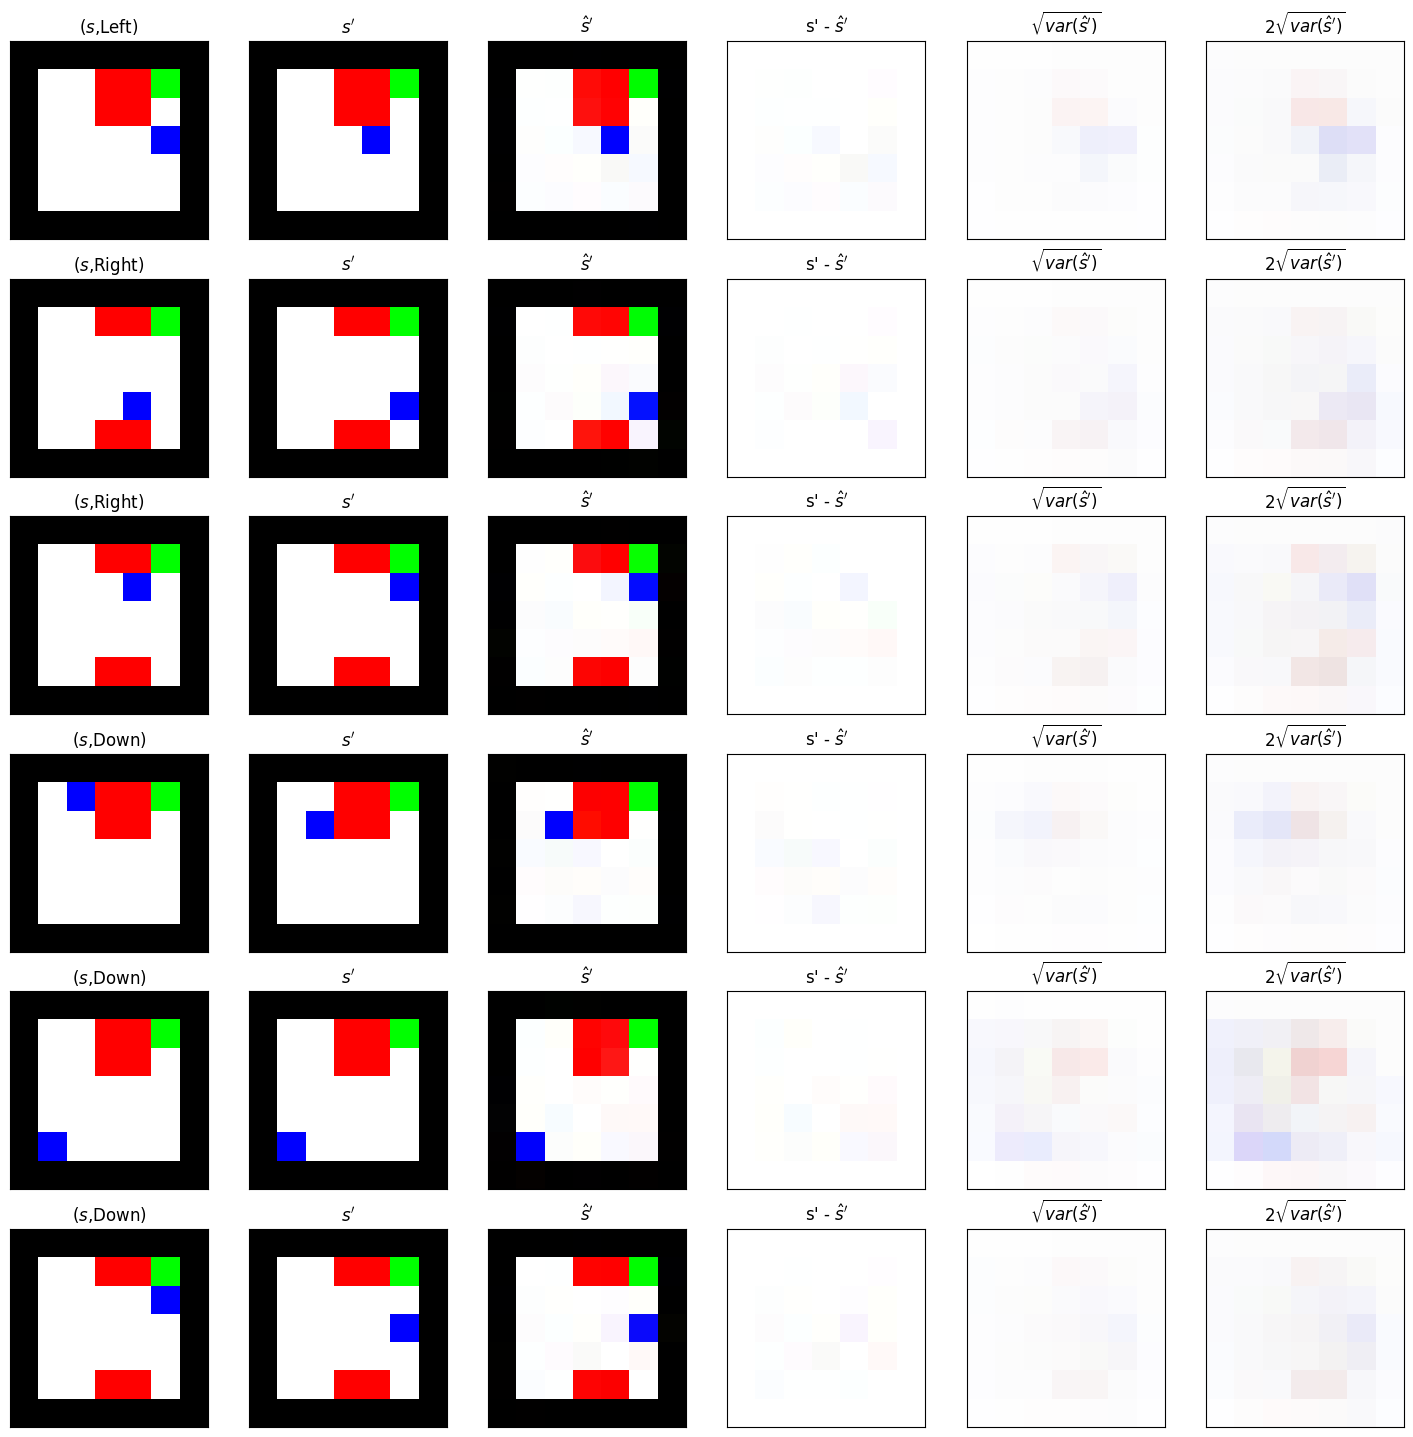

In [116]:
plot_predicted_transition_std(train_dataset, np.random.choice(len(train_dataset), size=6, replace=False), reshaped_prediction_train_uncertainty, filename=f"data/results/error_prop_train.png")

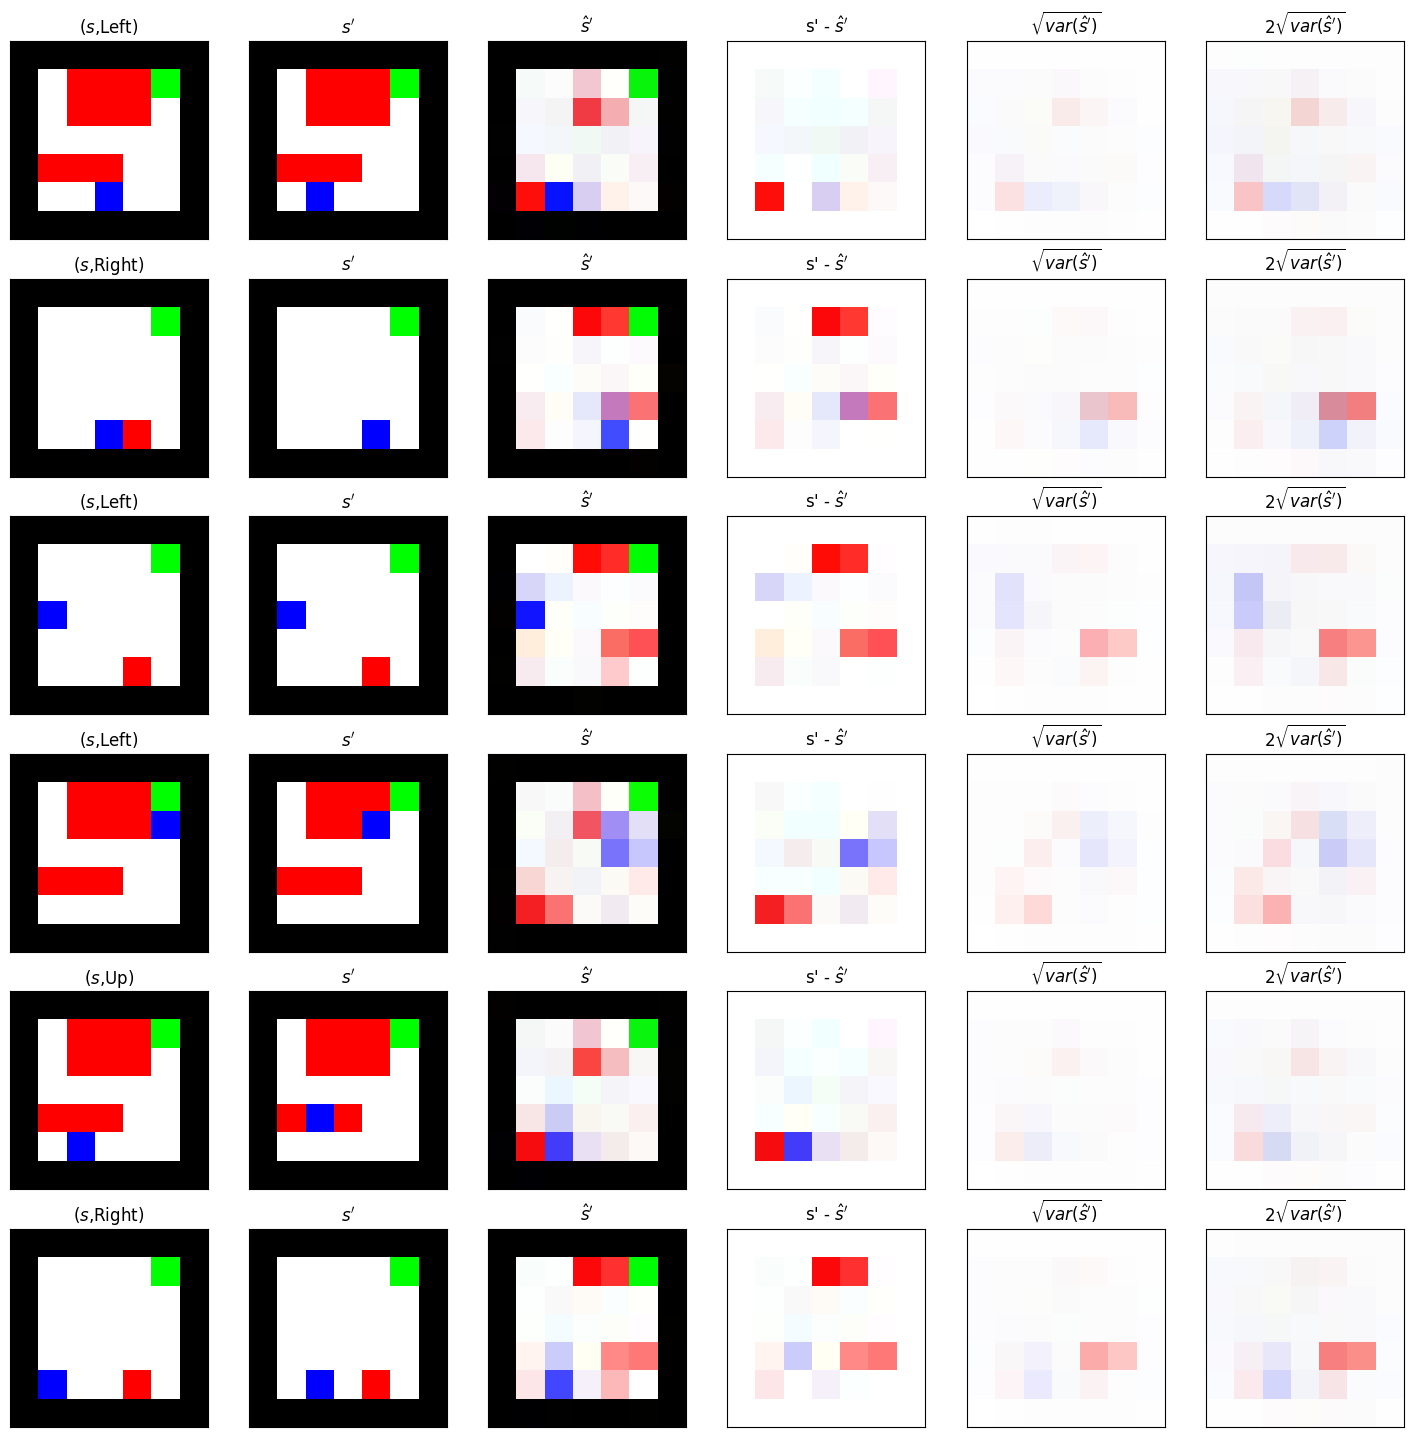

In [117]:
plot_predicted_transition_std(test_dataset, np.random.choice(len(test_dataset), size=6, replace=False), reshaped_prediction_test_uncertainty, filename=f"data/results/error_prop_test.png")

[[[0.00505647 0.00537874 0.00578303 0.00646864 0.00640874 0.00651059
   0.00640263]
  [0.00824662 0.00797814 0.01003061 0.01028539 0.01063096 0.00779691
   0.00650969]
  [0.00809136 0.00893593 0.01119727 0.01477946 0.01248018 0.01750112
   0.00751064]
  [0.00688471 0.00854314 0.01171271 0.03204431 0.0693159  0.03770659
   0.00637878]
  [0.00649412 0.00906166 0.01126031 0.01238822 0.04701559 0.01753573
   0.00538171]
  [0.00480948 0.00749933 0.00855855 0.01828853 0.01972413 0.01426642
   0.00486357]
  [0.00214114 0.00258173 0.00298909 0.00348449 0.00505755 0.00556462
   0.00365964]]

 [[0.00501034 0.00535833 0.00579618 0.00652369 0.00646105 0.00651007
   0.00639901]
  [0.00804851 0.0078844  0.00966933 0.02022888 0.01848151 0.00815607
   0.0065403 ]
  [0.00763948 0.0083909  0.01019865 0.01532636 0.01431426 0.01646834
   0.00744881]
  [0.00637835 0.00880731 0.02027019 0.03405674 0.06543539 0.03647572
   0.00555925]
  [0.00590657 0.00856193 0.01056463 0.01485355 0.04375179 0.02129104
   0.

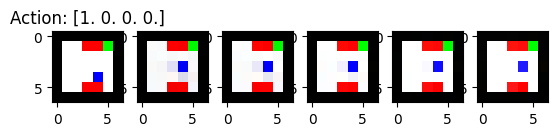

In [29]:
plot_predicted_transition_std(train_dataset, 60, reshaped_prediction_train_uncertainty)

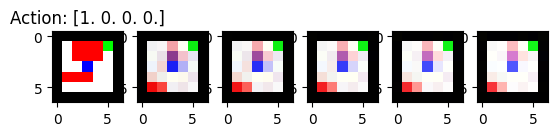

In [25]:
plot_predicted_transition_std(test_dataset, 20, reshaped_prediction_test_uncertainty)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true transition


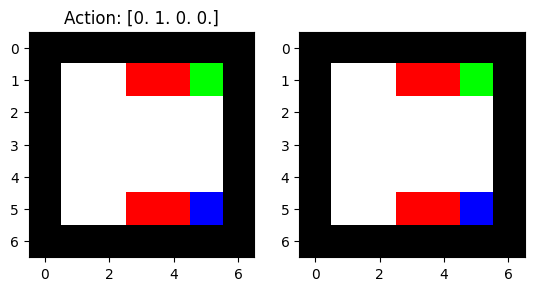

summed pixel uncertainties
[[ 3.82  4.24  4.25  4.87  4.96  5.17  5.1 ]
 [ 6.51  7.51  9.74 31.37 35.78 17.07  5.45]
 [ 7.95 11.33 15.87 19.25 18.31 18.58  6.61]
 [ 7.47 11.6  17.04 26.33 18.16 23.89  7.08]
 [ 6.66 11.82 19.1  25.96 77.87 57.73 18.97]
 [ 4.02 13.79 12.09 84.16 86.22 55.96 20.15]
 [ 1.48  4.05  8.25 17.74 21.51 29.3   4.39]]

predicted transition


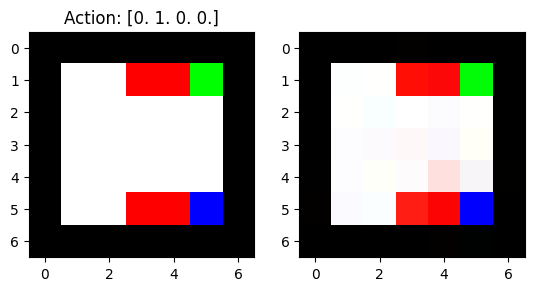

In [36]:
# plot_predicted_transitions(train_dataset, 38, prediction_uncertainty * 255)
plot_predicted_transitions(train_dataset, 77, reshaped_prediction_uncertainty  * 255)

In [40]:
# plot_predicted_transitions(test_dataset, 18, test_prediction_uncertainty_upscaled * 255)

In [33]:
np.histogram(reshaped_prediction_uncertainty.sum(1) * 255)

(array([5738, 1521,  374,  118,   49,   20,   10,    6,    3,    1]),
 array([  0.84,  12.33,  23.83,  35.32,  46.82,  58.31,  69.81,  81.3 ,
         92.79, 104.29, 115.78], dtype=float32))

In [35]:

# np.histogram(np.clip(test_prediction_uncertainty_upscaled * 255, 0, 10))
# np.where(prediction_uncertainty * 255 = 0)
np.where((reshaped_prediction_uncertainty.sum(1) * 255) > 40)

(array([  0,   3,   3,   3,   4,   4,   5,   5,  16,  16,  17,  20,  20,
         20,  20,  20,  24,  24,  24,  24,  24,  25,  25,  25,  25,  25,
         27,  31,  40,  45,  45,  45,  51,  58,  58,  62,  62,  62,  65,
         65,  65,  66,  66,  66,  70,  70,  71,  71,  73,  73,  74,  74,
         74,  75,  77,  77,  77,  77,  77,  78,  78,  78,  78,  78,  78,
         79,  79,  80,  80,  81,  83,  83,  83,  83,  84,  84,  84,  84,
         85,  85,  85,  85,  87,  88,  91,  92,  92,  93,  96,  96,  96,
         96,  96,  97,  97,  97,  97,  97,  99,  99, 103, 103, 105, 108,
        109, 112, 112, 115, 116, 116, 117, 117, 117, 117, 122, 123, 128,
        130, 132, 137, 137, 137, 142, 142, 142, 142, 143, 143, 145, 146,
        146, 147, 150, 154, 155, 157, 157, 157, 157, 158, 158, 158, 158,
        158, 158]),
 array([5, 1, 2, 5, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 5, 5, 1,
        2, 4, 5, 5, 2, 3, 2, 3, 5, 5, 4, 5, 5, 4, 5, 5, 4, 5, 5, 4, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 

In [34]:
idx = 10
flat_param_dict["indices"][idx], flat_param_dict["names"][idx]

((9648, 14256), 'state_decoder.0.net.0.weight')

# Other

In [91]:
def plot_models_param_std(transition_start_idx, decoder_start_idx):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    indices = [0, transition_start_idx, decoder_start_idx, len(parameter_var)]
    names = ['encoder', 'transition', 'decoder']
    for idx, ax in enumerate(axes):
        model_param_var = parameter_var[indices[idx]:indices[idx+1]]
        # ax.scatter(range(len(model_param_var)), np.sqrt(model_param_var))
        ax.scatter(range(len(model_param_var)), np.sqrt(model_param_var))
        ax.set_yscale('log')
        # ax.set_ylim(1e-22, 1e-3)
        ax.set_title(names[idx])
    plt.show()

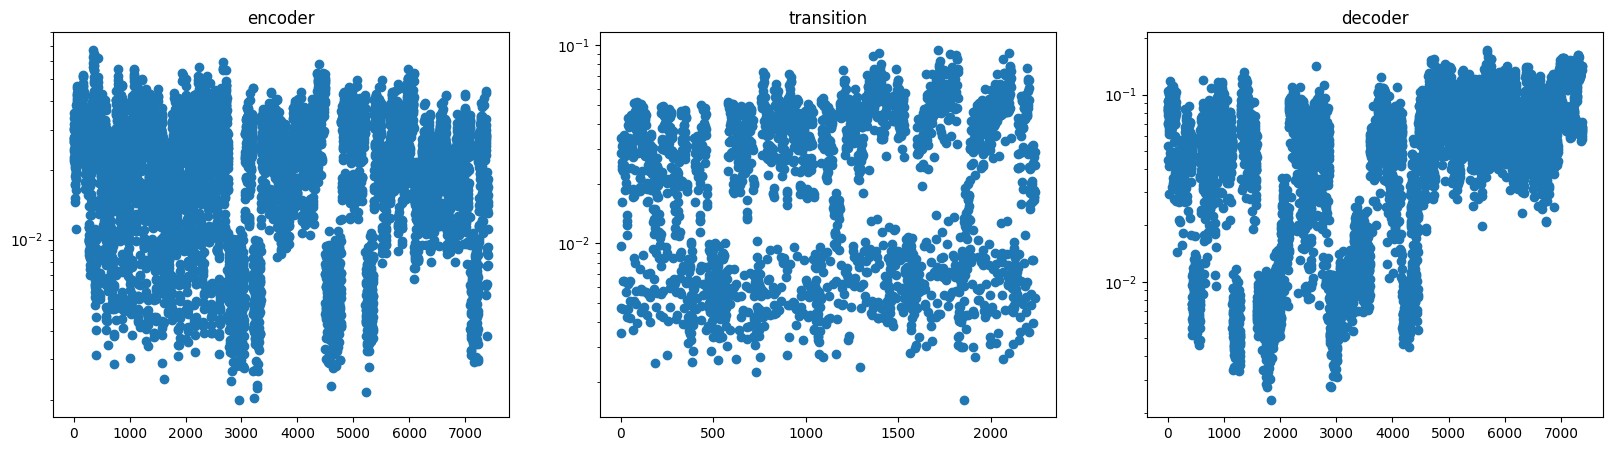

In [92]:
plot_models_param_std(7408, 9648)

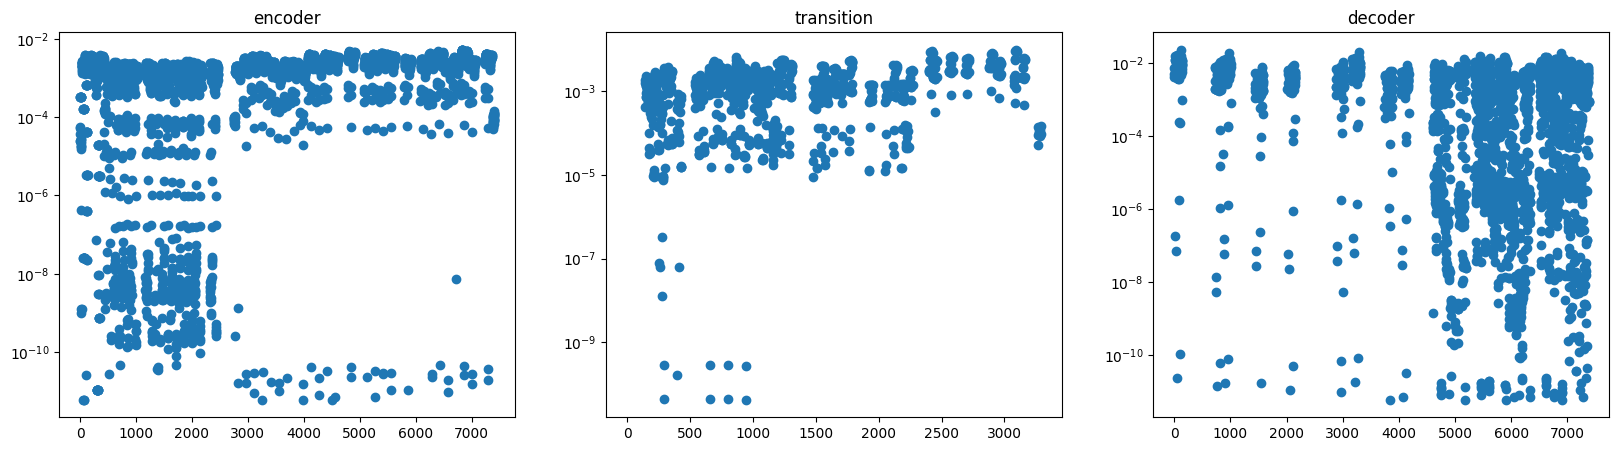

In [54]:
# OLD MODEL trained only on distshift1
plot_models_param_std(7408, 10704)

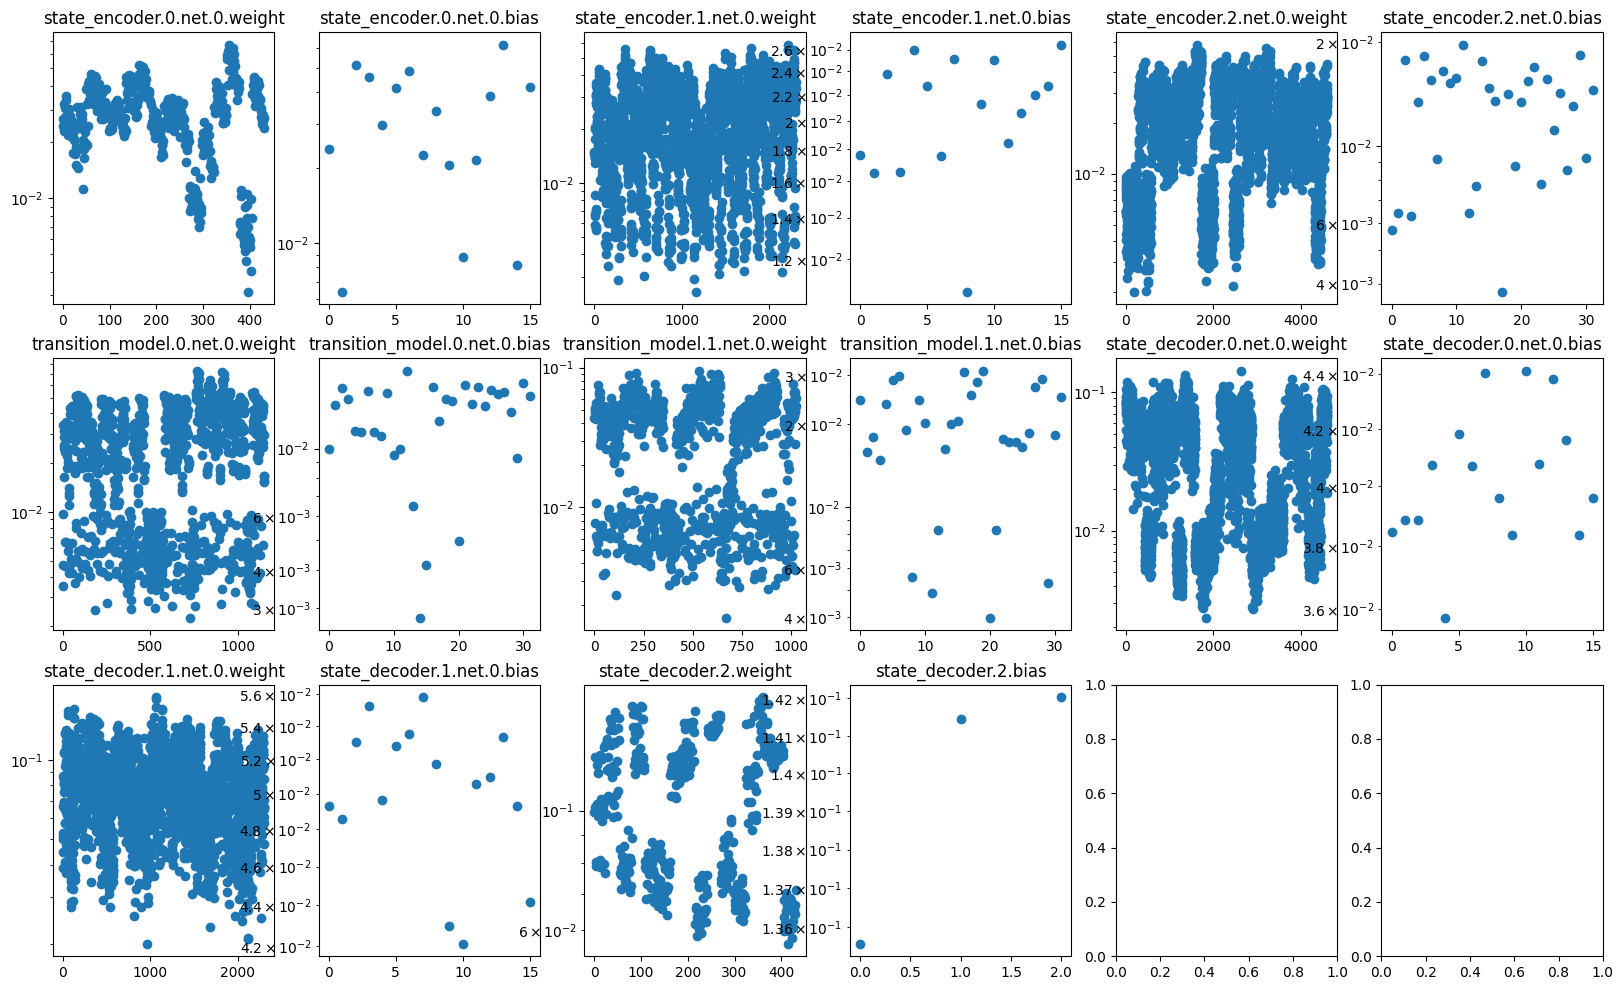

In [93]:
def plot_named_param_std(names, indices):
    fig, axes = plt.subplots(3, 6, figsize=(20, 12))
    offset = 0
    for i, (name, min_max_indices) in enumerate(zip(names, indices)):
        ax = axes[np.unravel_index(i, (3, 6))]
        model_param_var = parameter_var[min_max_indices[0]:min_max_indices[1]]
        ax.scatter(range(len(model_param_var)), np.sqrt(model_param_var))
        # ax.set_ylim(min_parameter_var, max_parameter_var)
        ax.set_yscale('log')
        # ax.set_ylim(1e-22, 1e-3)
        ax.set_title(name)
    plt.show()
    
plot_named_param_std(flat_param_dict["names"], flat_param_dict["indices"])

In [101]:
# parameter_std = np.sqrt(parameter_var)
certain_params = []
uncertain_params = []
# median_uncertainty = np.median(parameter_var)
mean_uncertainty = np.mean(parameter_var)
for param_std, param in zip(parameter_var, flat_param_dict["params"].cpu().detach().numpy()):
    # if param_std < median_uncertainty:
    if param_std < mean_uncertainty:
        certain_params.append(param)
    else:
        uncertain_params.append(param)

In [11]:
# import numpy as np
# cov_lava = np.load(f"data/feature_fims_inv/lava.npz")["arr_0"]
# cov_wall = np.load(f"data/feature_fims_inv/wall.npz")["arr_0"]
cov_player = np.load(f"data/feature_fims_inv/player.npz")["arr_0"]

In [8]:
def plot_param_std2(param_std, transition_start_idx=7408, decoder_start_idx=10704): 
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    indices = [0, transition_start_idx, decoder_start_idx, len(param_std)]
    names = ['encoder', 'transition', 'decoder']
    for idx, ax in enumerate(axes):
        model_param_var = param_std[indices[idx]:indices[idx+1]]
        # ax.scatter(range(len(model_param_var)), np.sqrt(model_param_var))
        ax.scatter(range(len(model_param_var)), np.sqrt(model_param_var))
        ax.set_yscale('log')
        # ax.set_ylim(1e-22, 1e-3)
        ax.set_title(names[idx])
    plt.show()
    
    
plot_param_std2(np.sqrt(np.diag(cov_lava)))

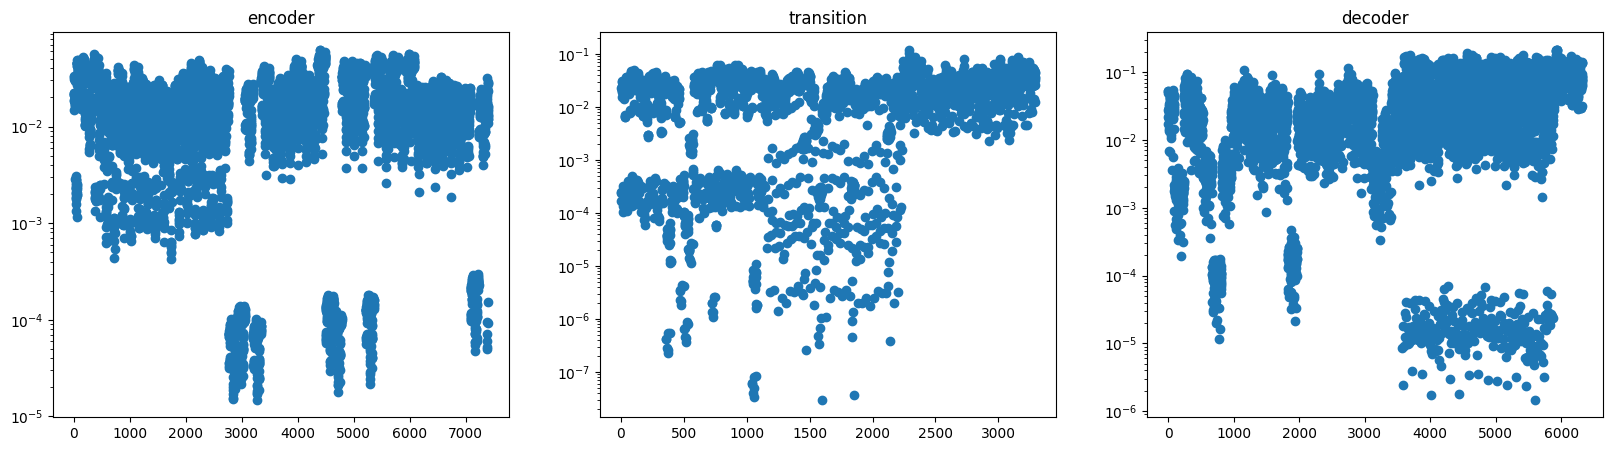

In [10]:
plot_param_std2(np.sqrt(np.diag(cov_wall)))

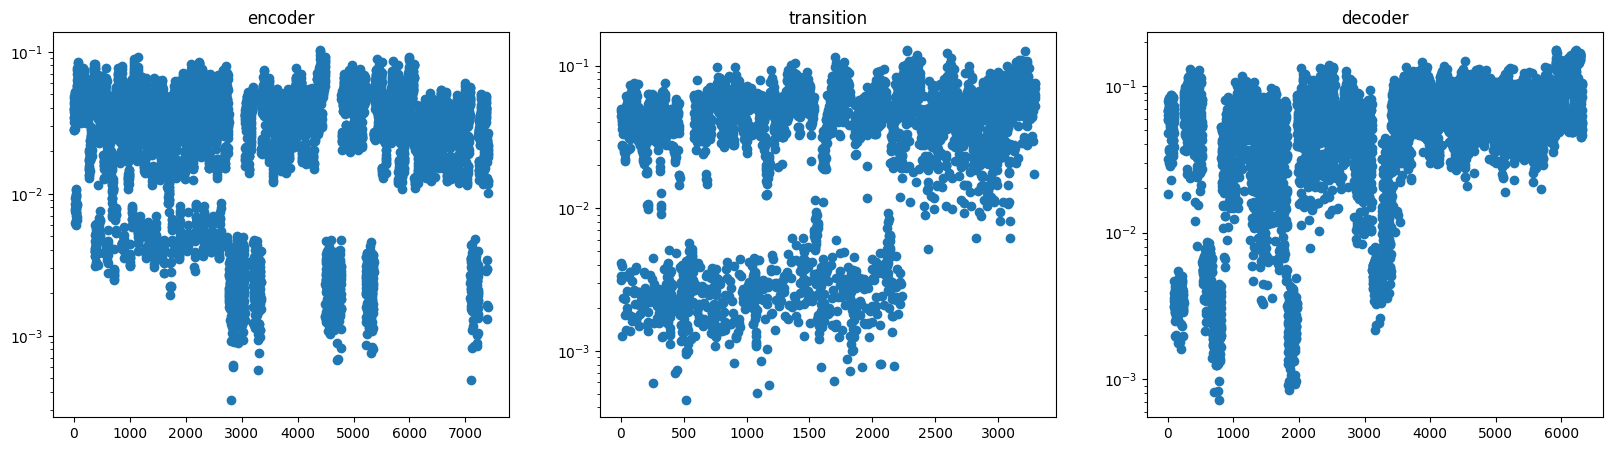

In [12]:
plot_param_std2(np.sqrt(np.diag(cov_player)))

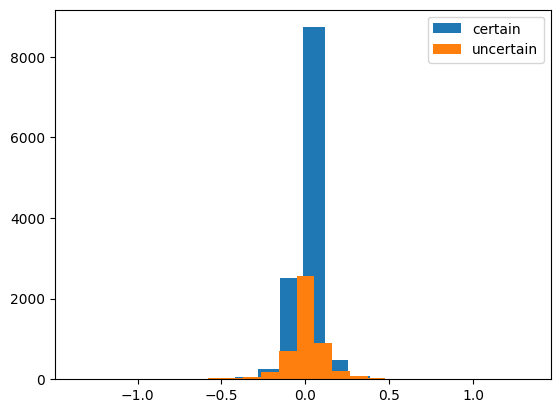

In [103]:
counts, bins = np.histogram(certain_params, bins=20)
plt.hist(bins[:-1], bins, weights=counts, label="certain")
counts, bins = np.histogram(uncertain_params, bins=20)
plt.hist(bins[:-1], bins, weights=counts, label="uncertain")


plt.legend()
plt.show()

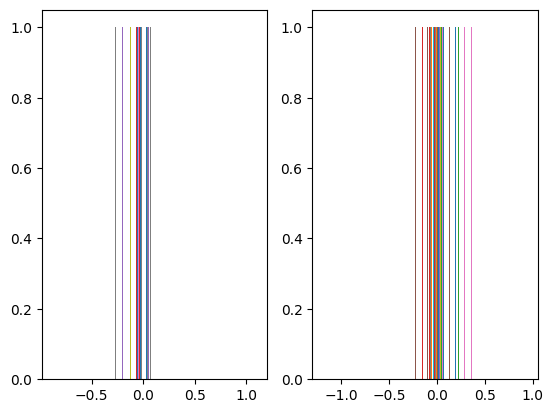

In [47]:
fig, axes = plt.subplots(1, 2)
for ax, params in zip(axes, [certain_params, uncertain_params]):
    ax.hist(certain_params)
    # ax.set_xscale('log')
# axes[1].hist(uncertain_params)

plt.show()

# Reshape feature fim invs

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
import json


import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd.functional import hessian

from distshift_dataset import UniqueDistshiftDataset
from models import AutoencodingWorldModel, SeparatedAutoencodingWorldModel
from train import get_dataloaders, device
from fim import get_and_save_FIM_data, load_FIM, load_FIM_inv

In [2]:
world_model = AutoencodingWorldModel(.001, hidden_layers=[16, 16, 32], transition_layers=[32])
# world_model.load_state_dict(torch.load(f"data/models/autoencoding_161632.ckpt"))
world_model.load_state_dict(torch.load(f"data/models/{world_model.model_name}_many.ckpt"))
world_model = world_model.to(device)

In [3]:
def flatten_params(model: nn.Module):
    """
    flattens all parameters into a single column vector. Returns the dictionary to recover them
    :param: parameters: a generator or list of all the parameters
    :return: a dictionary: {"params": [#params, 1],
    "indices": [(start index, end index) for each param] **Note end index in uninclusive**

    """
    flat_params = []
    names = []
    for (name, param) in model.named_parameters():
        flat_params.append(torch.flatten(param))
        names.append(name)
    # l = [torch.flatten(p) for p in parameters]
    
    indices = []
    s = 0
    for p in flat_params:
        size = p.shape[0]
        indices.append((s, s+size))
        s += size
    flat_params = torch.cat(flat_params).view(-1, 1)
    return {"params": flat_params, "indices": indices, "names": names}


def recover_flattened(flat_params, indices, names, model):
    """
    Gives a list of recovered parameters from their flattened form
    :param flat_params: [#params, 1]
    :param indices: a list detaling the start and end index of each param [(start, end) for param]
    :param model: the model that gives the params with correct shapes
    :return: the params, reshaped to the ones in the model, with the same order as those in the model
    """
    l = [flat_params[s:e] for (s, e) in indices]
    for i, p in enumerate(model.parameters()):
        l[i] = l[i].view(*p.shape)
    from collections import OrderedDict
    
    state_dict = OrderedDict()
    for n, p in zip(names, l):
        state_dict[n] = p
    return state_dict
    # return l

In [4]:
flat_param_dict = flatten_params(world_model)

In [6]:
dir = f"data/feature_fims_inv/"
for filename in os.listdir(dir):
    cov = np.load(dir + filename)["arr_0"]
    print(filename, cov.shape)
    feature = filename.split('.')[0]
    param_std = np.sqrt(np.diag(cov))
    reshaped_param_std = recover_flattened(torch.from_numpy(param_std), flat_param_dict["indices"], flat_param_dict["names"], world_model)
    
    data = {}
    for name, tensor in reshaped_param_std.items():
        data[name] = tensor.tolist()
    data

    with open(f"data/feature_fims_inv/{feature}_reshaped.json", "w") as outfile: 
        json.dump(data, outfile)

goal.npz (17027, 17027)
floor.npz (17027, 17027)
player_next_state.npz (17027, 17027)
floor_next_state.npz (17027, 17027)
player.npz (17027, 17027)
wall.npz (17027, 17027)
wall_next_state.npz (17027, 17027)
lava.npz (17027, 17027)
lava_next_state.npz (17027, 17027)
goal_next_state.npz (17027, 17027)


In [11]:
cov1 = np.load(dir + "player_next_state.npz")["arr_0"]
cov2 = np.load(dir + "player.npz")["arr_0"]

In [12]:
cov1

array([[ 2.6573591e-06, -5.3419654e-08, -6.1423935e-07, ...,
         5.1015303e-07,  2.9608961e-07, -1.7485518e-06],
       [-5.3419654e-08,  1.9982770e-06, -3.6353063e-07, ...,
         8.1155105e-07,  4.2123250e-07,  5.3809282e-07],
       [-6.1423935e-07, -3.6353066e-07,  6.2413915e-07, ...,
        -4.2501071e-07, -7.5083065e-08,  4.5080267e-07],
       ...,
       [ 5.1015303e-07,  8.1155110e-07, -4.2501068e-07, ...,
         1.0946873e-04, -6.5632856e-05, -2.3802439e-05],
       [ 2.9608964e-07,  4.2123239e-07, -7.5083008e-08, ...,
        -6.5632863e-05,  1.1450687e-04, -1.7890543e-05],
       [-1.7485518e-06,  5.3809299e-07,  4.5080273e-07, ...,
        -2.3802439e-05, -1.7890541e-05,  1.1781231e-04]], dtype=float32)

In [13]:
cov2

array([[ 2.6573591e-06, -5.3419654e-08, -6.1423935e-07, ...,
         5.1015303e-07,  2.9608961e-07, -1.7485518e-06],
       [-5.3419654e-08,  1.9982770e-06, -3.6353063e-07, ...,
         8.1155105e-07,  4.2123250e-07,  5.3809282e-07],
       [-6.1423935e-07, -3.6353066e-07,  6.2413915e-07, ...,
        -4.2501071e-07, -7.5083065e-08,  4.5080267e-07],
       ...,
       [ 5.1015303e-07,  8.1155110e-07, -4.2501068e-07, ...,
         1.0946873e-04, -6.5632856e-05, -2.3802439e-05],
       [ 2.9608964e-07,  4.2123239e-07, -7.5083008e-08, ...,
        -6.5632863e-05,  1.1450687e-04, -1.7890543e-05],
       [-1.7485518e-06,  5.3809299e-07,  4.5080273e-07, ...,
        -2.3802439e-05, -1.7890541e-05,  1.1781231e-04]], dtype=float32)